In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageFile
import pandas as pd
import seaborn as sns
import networkx as nx
from kneed import KneeLocator
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from graphutils import GraphUtils
from randomwalkkernel import RandomWalkKernel
from shortestpathkernel import ShortestPathKernel
import json
import math

samples = [2, 11, 14, 15, 18, 19, 27, 33, 45]

TRIAL_NUMBER = 1
SUBJECT = 4



subjects_full = [1, 2, 3, 4, 7, 9, 10, 12, 13, 14]
trials_full = [14, 27, 45, 1, 27, 22, 31, 32, 10, 1]

subjects = subjects_full[0:4]
trials = trials_full[0:4]

size = (1250, 740) # (900, 640)

def get_dataset(subject: int, trial: int):
    with open(f"../eyelink_output/sub_{subject}/images.json") as f:
        images = json.load(f)
    img_path = f"../test2017/test2017/{images[str(trial)]}"
    image = Image.open(img_path).resize(size) #.transpose(Image.FLIP_LEFT_RIGHT)
    file_path = f"../eyelink_output/sub_{subject}/trial_{trial}.csv"
    df_1 = pd.read_csv(file_path, sep="\t")
    return df_1, image


results_full = [get_dataset(subj, trial) for subj, trial in zip(subjects_full, trials_full)]
results = [get_dataset(subj, trial) for subj, trial in zip(subjects, trials)]

dfs, images = zip(*results)
dfs_full, images_full = zip(*results_full)


FileNotFoundError: [Errno 2] No such file or directory: '../eyelink_output/sub_1/images.json'

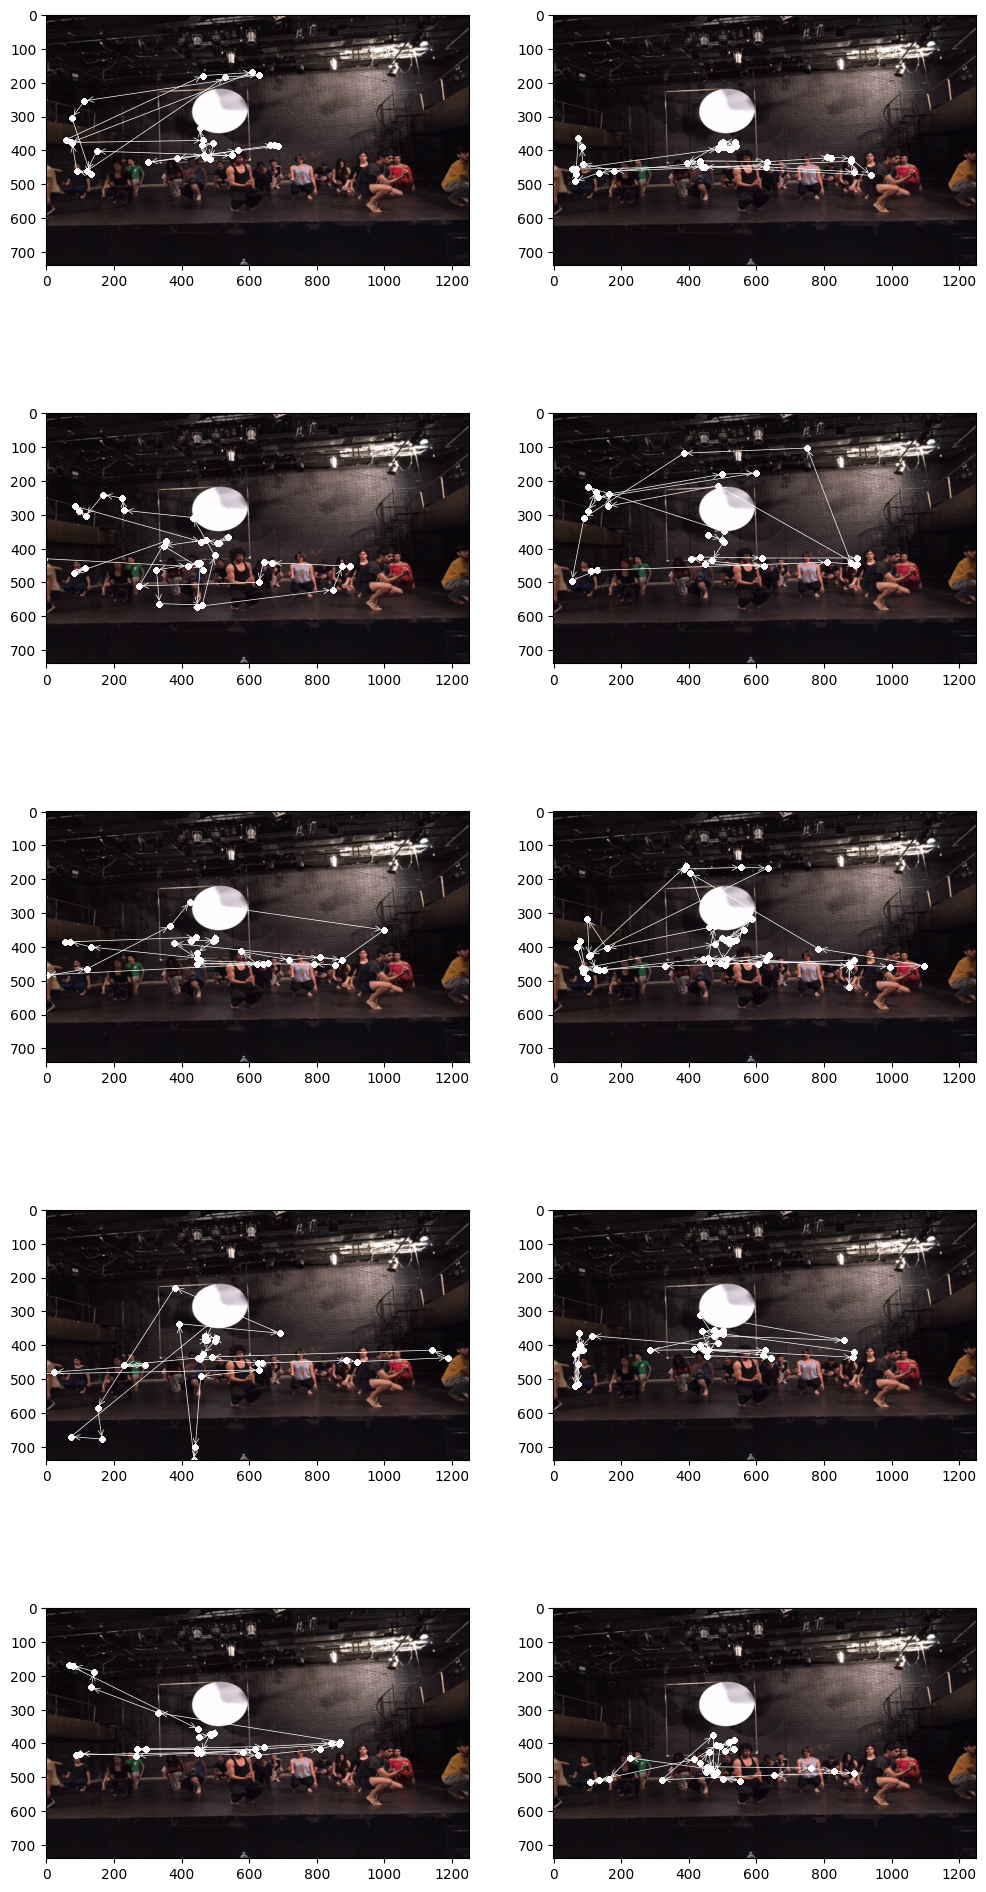

In [20]:
def wrap_subplots(n_plots: int, n_wrap: int):
    ncols = min(n_plots, n_wrap)
    nrows = math.ceil(n_plots / n_wrap)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 5))
    axs = axs.flatten()
    for ax in axs[n_plots:]:
        ax.axis("off")
    return fig, axs

def trace_plot(ax, df: pd.DataFrame):
    for i in range(len(df.index) - 1):
        ax.annotate( "", xy=(df["x"][i + 1], df["y"][i + 1]), xytext=(df["x"][i], df["y"][i]), arrowprops=dict(arrowstyle="->", color="white", lw=0.5),
        )
        ax.scatter(df["x"], df["y"], color="white", marker=".")

fig, ax = wrap_subplots(len(subjects_full), 2)

for i, (df, img) in enumerate(results_full):
    trace_plot(ax[i], df),
    ax[i].imshow(img)

In [8]:
def cluster(k_clusters: int, df: pd.DataFrame) -> tuple[pd.DataFrame, float]:

    X = df[["x", "y"]]
    kmeans = KMeans(n_clusters=k_clusters, random_state=0)
    kmeans.fit(X)
    df_copy = df.copy()
    df_copy["AOI"] = kmeans.labels_

    return df_copy, kmeans.inertia_


def clustering(min_clusters: int, max_clusters: int, df: pd.DataFrame) -> tuple[dict[int, pd.DataFrame], dict[int, float]]:
    """Input:
    - min_clusters: inclusive
    - max_clusters: inclusive
    - data: has x,y columns, temporal order

    Return:
    - dict of k - fitted df, and dict of k - inertias
    """
    dfs:  dict[int, pd.DataFrame] = {}
    inertias: dict[int, float] = {}

    cluster_numbers = range(min_clusters, max_clusters+1)
    for k in cluster_numbers:
        df_copy, inertia = cluster(k, df)
        dfs[k] = df_copy
        inertias[k] = inertia

    return dfs, inertias


def transition_matrix(df: pd.DataFrame, normalize: bool=False) -> np.ndarray:
    """
    Inputs:
    - aoi: df with needed columns x, y
    - data: df wiht needed columns AOI
    
    Returns
    - n x n transition matrix, where n is the number of AOIs
    """

    # from \ to -> row \ col
    AOIS = len(df["AOI"].unique())
    transition_matrix = np.zeros(shape=(AOIS, AOIS), dtype=int)
    for i in range(len(df.index)-1):
        from_aoi = df.loc[i, "AOI"]
        to_aoi = df.loc[i+1, "AOI"]
        transition_matrix[from_aoi][to_aoi] += 1
    #rows_sum = np.sum(transition_matrix, axis=1)
    return transition_matrix #/ rows_sum


def elbow_plot(inertias: dict[int, float]) -> None:
    k_values, inertia_values = zip(*inertias.items())
    knee_locator = KneeLocator(k_values, inertia_values, curve='convex', direction='decreasing')
    k = knee_locator.knee
    _, ax = plt.subplots(1, 1, figsize=(6.5, 4))
    ax.plot(k_values, inertia_values, marker='o')
    ax.axvline(x=k, color="red")
    ax.set(xlabel='Number of clusters [-]', ylabel='Inertia [-]', title=f'Elbow method for optimal k')
    ax.set_xticks(k_values)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))


def cluster_plot(df: pd.DataFrame, image: ImageFile, ax):
    sns.scatterplot(data=df, x='x', y='y', hue='AOI', palette='deep', s=80, ax=ax)
    if image:
        ax.imshow(image)

def cluster_plots(dfs: dict[int, pd.DataFrame], image: ImageFile, title: str=""):
    fig, axs = plt.subplots(nrows=1, ncols=len(dfs), figsize=(30, 4))
    fig.suptitle(title)
    for i, kv in enumerate(dfs.items()):
        k, df = kv
        cluster_plot(df, image, axs[i])


In [9]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 6


matrices = []
matrices_norm = []
graphs = []

for  i, (df, img) in enumerate(results_full):
    td_dfs, td_inertias = clustering(MIN_CLUSTERS, MAX_CLUSTERS, df)

    #elbow_plot(td_inertias)

    #cluster_plots(td_dfs, img, f"Sample {i+1} - clusters")


    #td_fig_maps, td_axs_maps = plt.subplots(nrows=1, ncols=len(td_dfs), figsize=(20, 3))
    #td_fig_maps.suptitle(f"Sample {i+1} - heatmaps")
    for i, df in enumerate(td_dfs.values()):
        m = GraphUtils.transition_matrix(df)
        m_norm = GraphUtils.transition_matrix(df, normalize=True)
        if i == 1:
            matrices.append(m)
            matrices_norm.append(m_norm)
        # GraphUtils.heatmap(m, td_axs_maps[i])


    #td_fig_graphs, td_axs_graphs = plt.subplots(nrows=1, ncols=len(td_dfs), figsize=(20, 3))
    #td_fig_graphs.suptitle(f"Sample {i+1} - graphs")
    for i, df in enumerate(td_dfs.values()):
        m = GraphUtils.transition_matrix(df)
        g = GraphUtils.transition_matrix_to_graph(m)
        if i == 1:
            graphs.append(g)
       # GraphUtils.draw(G=g, weights=True, ax=td_axs_graphs[i])


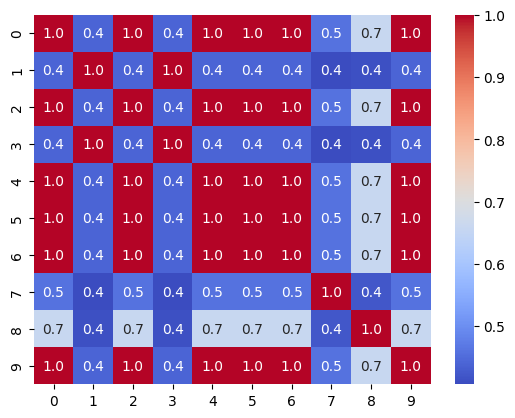

In [10]:
from wl import WL
from labelhasher import LabelHasher

wl = WL(LabelHasher())

WL_REFINEMENT_STEPS = 4
train_matrix = np.zeros(shape=(len(graphs), len(graphs)))

for i, g1 in enumerate(graphs):
    for j, g2 in enumerate(graphs):
        v = wl.get_feature_vectors(g1, g2, WL_REFINEMENT_STEPS)
        K = wl.get_kernel_value(v, normalize=True)
        train_matrix[i][j] = K

GraphUtils.heatmap(train_matrix)

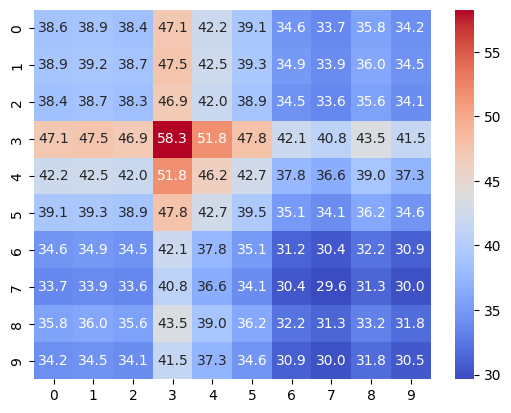

In [11]:

train_matrix = np.zeros(shape=(len(graphs), len(graphs)))

for i, g1 in enumerate(matrices):
    for j, g2 in enumerate(matrices):
        K = RandomWalkKernel.weighted_random_walk_kernel(g1, g2)
        train_matrix[i][j] = K

GraphUtils.heatmap(train_matrix)

In [ ]:
# these are the actual lables "reponse", "image_name", "label", "response", "target_label"

import pandas as pd


df = pd.read_csv(f"../gaze3p/subject-1.csv")
for i, x in enumerate(df["response"]):
    print(i, x)


0 nan
1 4 (neutral)
2 3
3 2
4 4 (neutral)
5 7 (non sensitive)
6 7 (non sensitive)
7 1 (privacy sensitive)
8 2
9 4 (neutral)
10 2
11 4 (neutral)
12 5
13 1 (privacy sensitive)
14 3
15 1 (privacy sensitive)
16 7 (non sensitive)
17 7 (non sensitive)
18 7 (non sensitive)
19 2
20 2
21 6
22 5
23 3
24 7 (non sensitive)
25 7 (non sensitive)
26 2
27 4 (neutral)
28 4 (neutral)
29 5
30 4 (neutral)
31 1 (privacy sensitive)
32 2
33 4 (neutral)
34 2
35 4 (neutral)
36 1 (privacy sensitive)
37 7 (non sensitive)
38 4 (neutral)
39 2
40 2
41 3
42 7 (non sensitive)
43 4 (neutral)
44 3
45 4 (neutral)
46 7 (non sensitive)
47 6
48 3
49 2
50 3
51 2
52 7 (non sensitive)
53 1 (privacy sensitive)
54 4 (neutral)
55 6
56 1 (privacy sensitive)
57 1 (privacy sensitive)
58 4 (neutral)
59 3
60 2
61 1 (privacy sensitive)
62 1 (privacy sensitive)
63 2
64 1 (privacy sensitive)
65 7 (non sensitive)
66 1 (privacy sensitive)
67 7 (non sensitive)
68 2
69 4 (neutral)
70 6
71 2
72 2
73 1 (privacy sensitive)
74 3
75 2
76 2
77 4 